Importing libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import *
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

Reading and scaling data

In [ ]:
data_set = pd.read_csv("diabetes.csv")

#Resto dos dados
X = data_set.drop(columns=["Outcome"]).copy()
#Resultado: tem diabetes ou não
y = data_set["Outcome"].copy()


scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)  

#data fraem com os dados escalados
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)


PART A

A-1

In [ ]:
k_values = list(range(2, 12))
sse = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, max_iter=500, random_state=42, n_init="auto")
    #Treinar com os dados escalados
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)  #inertia_ é o SSE

#plottar
plt.figure(figsize=(8, 5))
plt.plot(k_values, sse, marker="o")
plt.xticks(k_values)
plt.xlabel("Cluster Number (k)")
plt.ylabel("SSE (Sum of squared Errors)")
plt.title("SSE vs Cluster Number")
plt.grid(alpha=0.3)
plt.tight_layout()
#plt.show()
plt.savefig("SSE.png")  # salvar a figura

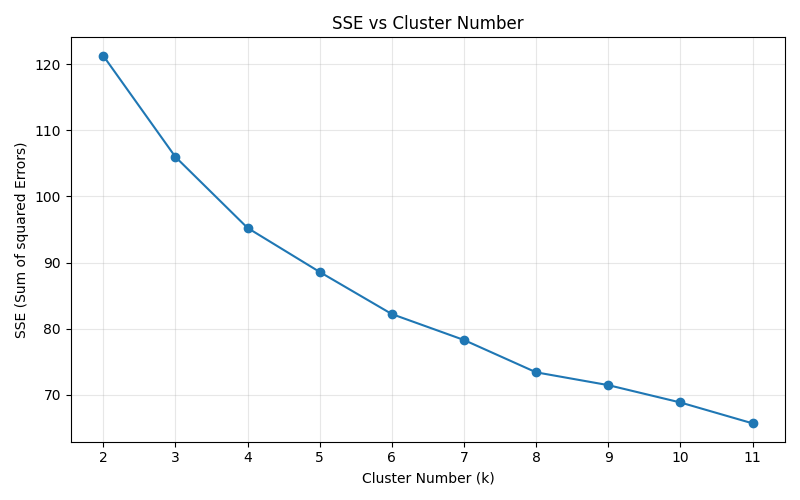

A-2

In [ ]:
#A-2
k_chosen = 6
kmeans6 = KMeans(n_clusters=k_chosen, max_iter=500, random_state=42, n_init="auto")
cluster_labels = kmeans6.fit_predict(X_scaled)

#Criar DataFrame para análise
df_clustered = X.copy()
df_clustered["Outcome"] = y.values #Valor real
df_clustered["cluster"] = cluster_labels #Resultado do k-means clustering


cluster_majority_label = {}
for c in range(k_chosen):
    labels_in_cluster = df_clustered.loc[df_clustered["cluster"] == c, "Outcome"]
    if len(labels_in_cluster) == 0:
        majority = 0 #caso raro: cluster vazio
    else:
        majority = labels_in_cluster.value_counts().idxmax()
    cluster_majority_label[c] = majority

pred_from_clusters = df_clustered["cluster"].map(cluster_majority_label).values

#Métricas: confusion matrix, accuracy, precision, recall, f1
cm = confusion_matrix(y, pred_from_clusters)
acc = accuracy_score(y, pred_from_clusters)
prec = precision_score(y, pred_from_clusters, zero_division=0)
rec = recall_score(y, pred_from_clusters, zero_division=0)
f1 = f1_score(y, pred_from_clusters, zero_division=0)

print("\nK-6 clustering method evaluation")
print("Confusion Matrix:\n", cm)
print(f"Accuracy: {acc:.4f}\n")
print(f"Precision: {prec:.4f}\n")
print(f"Recall: {rec:.4f}\n")
print(f"F1-score: {f1:.4f}\n")

K-6 clustering method evaluation
Confusion Matrix:
 [[390 110]
 [119 149]]
 
Accuracy: 0.7018

Precision: 0.5753

Recall: 0.5560

F1-score: 0.5655

This method uses unsupervised clusters in classifiers. Each cluster is assigned its majority class.
This method depends for its effectiveness on the fact of matching clusters and true classes. 
There may, however, be cases where a majority class is assigned to a cluster by a marginal 
difference between the two original classes present, which leads to a limited classification. The resulting 
accuracy (0.7018) is not so bad, yet the accuracy value would be higher case a supervised 
clustering model were used. For data that has no clear separations and natural groupings 
(as in medical datasets) K-means is not a valid classifier. It would be better to opt for a decision tree 
classifier

A-3

In [ ]:
#A-3
print("Distribution of the original classes (Outcome):\n")
print(y.value_counts())

#Centroids
centers_scaled = kmeans6.cluster_centers_
#Converter centroids para o espaço original (inverso do MinMax)
centers_original = scaler.inverse_transform(centers_scaled)
centers_df = pd.DataFrame(centers_original, columns=X.columns)
#Corresponder cada centro ao seu cluster
centers_df["cluster"] = range(k_chosen)

print("Centroids for each cluster:\n")
pd.set_option("display.precision", 4)
print(centers_df)

#Para escolher os 3 clusters mais discriminativos usamos purity
cluster_summary = []
for c in range(k_chosen):
    #Cada cluster
    sub = df_clustered[df_clustered["cluster"] == c]
    size = len(sub)
    #Contar as classes
    counts = sub["Outcome"].value_counts().to_dict()
    #Count = 0 se não houver
    count_0 = counts.get(0, 0)
    count_1 = counts.get(1, 0)
    majority_class = 0 if count_0 >= count_1 else 1
    majority_count = max(count_0, count_1)
    purity = majority_count / size if size > 0 else 0.0
    cluster_summary.append(
        {
            "cluster": c,
            "size": size,
            "count_0": count_0,
            "count_1": count_1,
            "majority_class": majority_class,
            "purity": purity,
        }
    )

cluster_summary_df = pd.DataFrame(cluster_summary).sort_values(
    by=["purity", "size"], ascending=[False, False]
)
print("Cluster Information (ordered by purity):\n")
print(cluster_summary_df)

#Selecionar os 3 mais discriminativos
top3 = cluster_summary_df.head(3)
print(" 3 Most discriminative clusters:\n")
print(top3)

print("Centroids (original) of the top-3 clusters:\n")
top3_centers = centers_df[centers_df["cluster"].isin(top3["cluster"].values)].set_index("cluster")
print(top3_centers)

In [ ]:
Distribution of the original classes (Outcome):

Outcome
0    500
1    268

Centroids for each cluster:

   Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  DiabetesPedigreeFunction      Age  cluster
0       1.8806  149.4701     7.4470e+01        34.1940  209.5746  37.0716                    0.6236  29.1269        0
1       1.7679   99.1036     6.6964e+01        23.6357   58.5857  30.0207                    0.4245  25.1857        1
2       5.9565  135.2029     8.0406e+01         5.1159    8.1304  29.5188                    0.4036  56.8116        2
3       3.6286  117.8000     1.3545e-14         1.5143    0.0000  25.7057                    0.3884  30.7143        3
4       4.8160  123.0560     7.3744e+01         1.6480    9.2080  31.8032                    0.4101  32.7600        4
5       8.5280  129.8800     7.6624e+01        31.6800  120.6960  34.2800                    0.5382  43.8720        5

Cluster Information (ordered by purity):

   cluster  size  count_0  count_1  majority_class  purity
1        1   280      254       26               0  0.9071
2        2    69       43       26               0  0.6232
5        5   125       49       76               1  0.6080
4        4   125       74       51               0  0.5920
0        0   134       61       73               1  0.5448
3        3    35       19       16               0  0.5429

 3 Most discriminative clusters:

   cluster  size  count_0  count_1  majority_class  purity
1        1   280      254       26               0  0.9071
2        2    69       43       26               0  0.6232
5        5   125       49       76               1  0.6080

Centroids (original) of the top-3 clusters:

         Pregnancies   Glucose  BloodPressure  SkinThickness   Insulin      BMI  DiabetesPedigreeFunction      Age
cluster                                                                                                           
1             1.7679   99.1036        66.9643        23.6357   58.5857  30.0207                    0.4245  25.1857
2             5.9565  135.2029        80.4058         5.1159    8.1304  29.5188                    0.4036  56.8116
5             8.5280  129.8800        76.6240        31.6800  120.6960  34.2800                    0.5382  43.8720

The three more discriminitive clusters were 1, 2 and 5. For both 2 and 5, because their purity
is relatively low we can not safely conclude that the values represented in their centroids
(Pregnancy, glucose, Blood pressure, etc) are safe indicators for their respective majority class
(0 and 1, respectively). Only thing we can conclude is that there is a majority of a single class 
in each one. 
For cluster 1, however, with a purity of 0.9071, we can use as a classifier the values represented
in its centroid as typical characteristics of a patient without diabetes, which means that most 
patients in this cluster are safe from diabetes.

PART B

B-1

In [ ]:
#PARTE B


#B-1
pca = PCA()
pca.fit(X_scaled)  #aplica no conjunto normalizado
#Explained variance
explained_variance_ratio = pca.explained_variance_ratio_
#Cumulative explained variance
cumvar = np.cumsum(explained_variance_ratio)

#plottar
plt.figure(figsize=(8, 5))
components = np.arange(1, len(cumvar) + 1)
plt.plot(components, cumvar, marker="o")
plt.xlabel("Principal Components")
plt.ylabel("Cumulative explained variance")
plt.title("PCA vs Cumulative explained variance")
plt.grid(alpha=0.3)
plt.axhline(0.80, color="gray", lw=1, linestyle="--")
plt.xticks(components)
plt.tight_layout()
#plt.show()
plt.savefig("B-1.png")

#Quantos componentes para >= 80?
#n_components_80 = int(np.searchsorted(cumvar, 0.80) + 1)
#print(f"Number of principal components needed for a >= 80% variance: {n_components_80}")

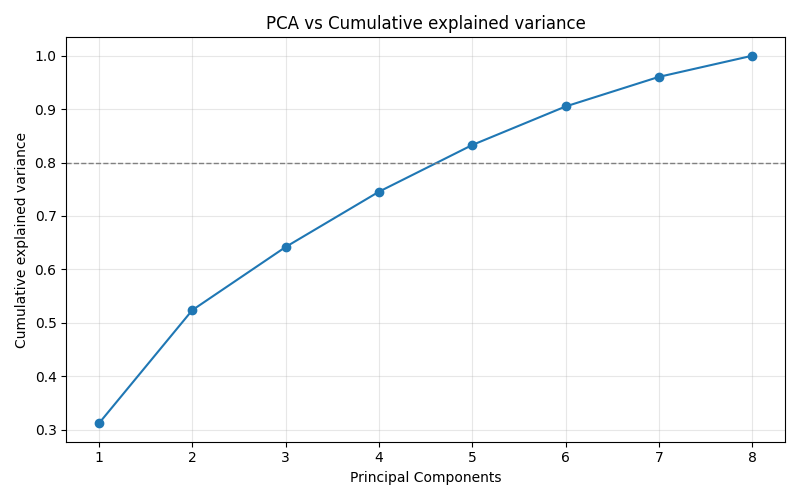

As it can be analyzed on the graph, for a 0.8 cummulative explained variance, we need at least 5 
principal components.

B-2

In [ ]:
#B-2
#PCA só com 1 componente
pca1 = PCA(n_components=1)
pc1 = pca1.fit_transform(X_scaled).ravel()

plt.figure(figsize=(8, 5))
plt.hist(pc1[y == 0], bins=30, alpha=0.6, label="Class 0 (no diabetes)")
plt.hist(pc1[y == 1], bins=30, alpha=0.6, label="Class 1 (diabetes)")
plt.xlabel("1st Principal Component (PC1)")
plt.ylabel("Frequency")
plt.title("Distribution of Classes along the 1st Principal Component")
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig("B-2.png")

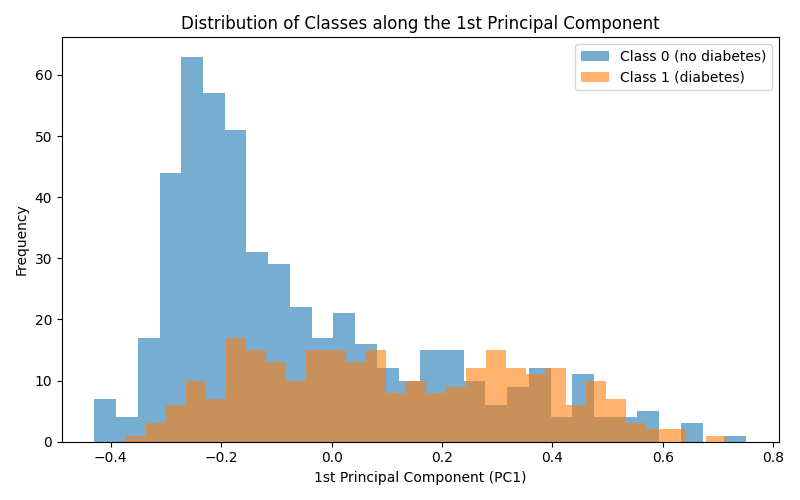

The histogram above shows the distribution of both classes throughout the PC1. Because we observe sevral overlap for all of the 
PC1 distribution, we can conclude that PC1 is not separating and classifying properly the classes (this because PCA is not a supervised
method)

B-3


In [ ]:
#B-3
#Só temos duas classes (0 e 1), logo LDA pode ter no máximo 1 componente
lda = LinearDiscriminantAnalysis(n_components=1)
lda_proj = lda.fit_transform(X_scaled, y).ravel()

plt.figure(figsize=(8, 5))
plt.hist(lda_proj[y == 0], bins=30, alpha=0.6, label="Class 0 (no diabetes)")
plt.hist(lda_proj[y == 1], bins=30, alpha=0.6, label="Class 1 (diabetes)")
plt.xlabel("LDA Component 1")
plt.ylabel("Frequency")
plt.title("Distribution of Classes along the LDA Component 1")
plt.legend()
plt.tight_layout()
#plt.show()
plt.savefig("B-3.png")

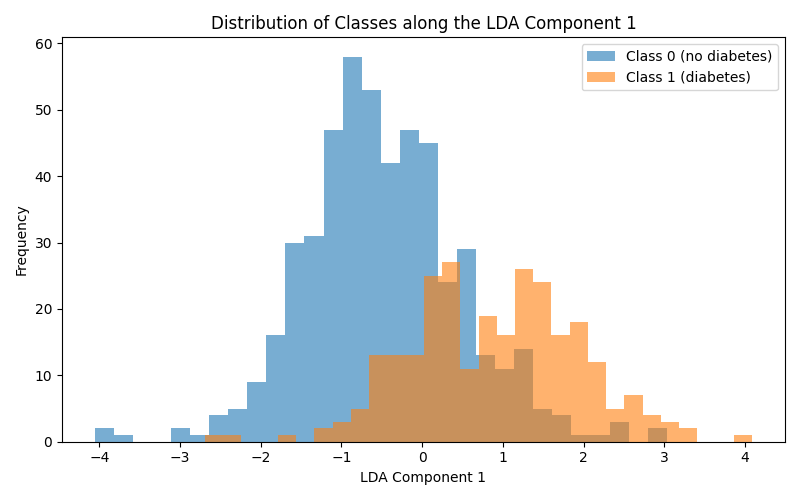

In this case, there is considerably less overlap (specially in ranges were the frequency of a class is superior to that
of the other). This shows a better classifying process by LDA in comparisson to PCA

B-4


LDA. PCA reduces dimensionality while preserving variance. Useful for compression and visualization, 
but it does not optimize separation between classes. LDA is designed to discriminate classes
(supervised) and is often more suitable. Based on the histograms of PC1 vs LDA, LDA offers better class
separation and less overlap. Therefore, for building a discriminator, LDA is the most appropriate choice.